In [2]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import *
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from qumcmc.quantum_mcmc_routines_qulacs import *  #for qulacs backend (**faster)
# from QuantumSamplingRoutines import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, transpiler
from qiskit.visualization import *
from qiskit_ibm_provider import IBMProvider
# # provider = IBMProvider(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628')
# # provider.save_account(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628', overwrite= True)
# provider = IBMProvider()


In [5]:
ibmq_guadalupe = provider.get_backend('ibmq_guadalupe'); ibmq_lima = provider.get_backend('ibmq_lima')

#### **Testing Backend**

In [3]:
node_to_qubit_map = {0: 0, 1:1, 2:2, 3:3, 4:4, 5:6, 6:7, 7: 10}
qubit_to_node_map = dict([(item[1], item[0]) for item in node_to_qubit_map.items()])

map_node_to_qubit = lambda x: node_to_qubit_map[x]
map_qubit_to_node = lambda x: qubit_to_node_map[x]
device_nodes = [0,1,2,3,4,6,7,10]
device_edges = [(0,1),(1,4),(4,7),(7,10),(7,6),(1,2),(2,3)]

graph_nodes = [0,1,2,3,4,5,6,7]

graph_edges = []
for edge in device_edges:
    i = map_qubit_to_node(edge[0])
    j = map_qubit_to_node(edge[1])
    new_edge = (i,j)
    graph_edges.append(new_edge)
    
trial_graph = nx.Graph(name= "ising_1")
trial_graph.add_nodes_from(graph_nodes)
trial_graph.add_edges_from(graph_edges)

h = [0.1, 0.3, 0.4, 0.21, 0.38, 0.15, 0.25, 0.10]
node_attr = {}
for index, node in enumerate(trial_graph.nodes) :

    node_attr[node] = {'h': np.round(h[index] * np.random.choice([1, -1]), 2)}

nx.set_node_attributes(trial_graph, node_attr)
edge_attr = {}
for edge in trial_graph.edges :
    edge_attr[edge] = {'J': np.round(np.random.uniform(-1,1),2)}

nx.set_edge_attributes(trial_graph, edge_attr)

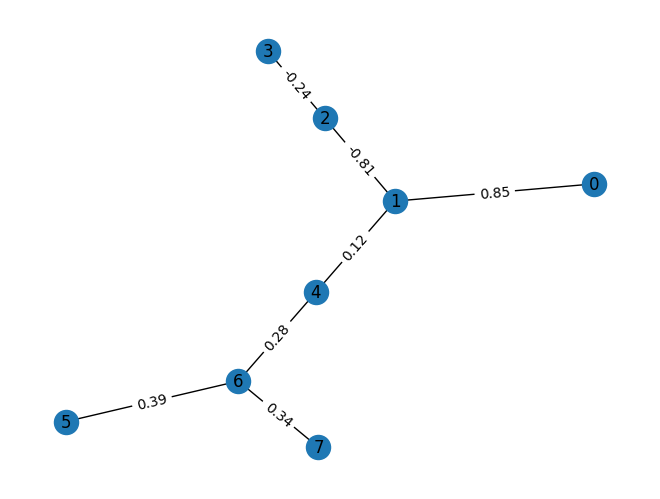

In [4]:
pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True,)
nx.draw_networkx_edge_labels(trial_graph, pos, edge_labels= nx.get_edge_attributes(trial_graph, 'J'));
# nx.draw_networkx_labels(trial_graph, pos, labels= nx.get_node_attributes(trial_graph, 'h'))


In [5]:
def build_energy_function_from_graph(graph: nx.Graph, name:str = 's'):
    
    nspins = graph.number_of_nodes()
    j = nx.get_edge_attributes(graph, 'J')
    J = np.zeros((nspins, nspins))

    for edge in graph.edges():
        J[edge[0], edge[1]] = j[edge]
        J[edge[1], edge[0]] = j[edge]

    H = list(nx.get_node_attributes(graph, 'h').values())    

    return IsingEnergyFunction(J =J, h=H, name= 'sm1')

In [6]:
model = build_energy_function_from_graph(trial_graph)

            MODEL : sm1
Non-zero Interactions (J) : 7 / 28
Non-zero Bias (h) : 8 / 8
---------------------------------------------
Average Interaction Strength <|J|> :  0.09468750000000001
Average Bias Strength <|h|>:  0.23625000000000002
alpha :  1.848921642026967
---------------------------------------------


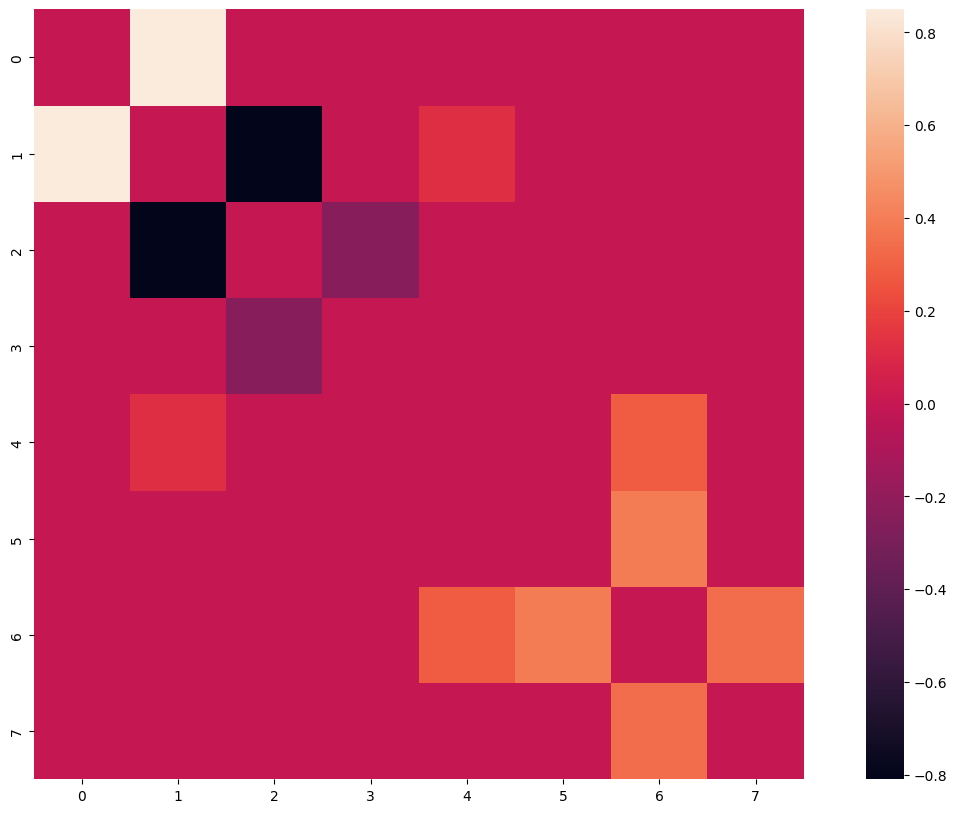

In [7]:
model.model_summary()

In [8]:
from QuantumSamplingRoutines_s import QuantumSamplingJob


In [9]:
sjob = QuantumSamplingJob(model)

In [10]:
gamma= 0.4 ; time= 1.0 
sjob.run_quantum_circuit(gamma, time, num_shots= 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


#### Final trial

In [6]:
sampling_job = QuantumSamplingJob(model, ibmq_guadalupe, backend_layout= [1,2])

In [83]:
gamma= 0.4 ; time= 1.0 

qcs = sampling_job.run_quantum_circuit(gamma, time, return_quantum_circuit= True)
qcs = transpile(qcs, ibmq_guadalupe, optimization_level=3, initial_layout= list(node_to_qubit_map.values()) )

In [91]:
qcs.draw()

global phase: 2π
                ┌─────────┐┌────┐┌─────────┐┌─┐┌────────────┐    ┌────┐    »
      q1_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├┤ Rz(1.8623) ├────┤ √X ├────»
                ├─────────┤├────┤├─────────┤└╥┘└────┬─┬─────┘┌───┴────┴───┐»
      q1_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──────┤M├──────┤ Rz(2.7624) ├»
                ├─────────┤├────┤├─────────┤ ║      └╥┘      └────┬─┬─────┘»
      q1_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫────────────┤M├──────»
                ├─────────┤├────┤├─────────┤ ║       ║            └╥┘      »
      q1_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫─────────────╫───────»
                ├─────────┤├────┤├─────────┤ ║       ║             ║       »
      q1_4 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫─────────────╫───────»
                └─────────┘└────┘└─────────┘ ║       ║             ║       »
 ancilla_0 -> 5 ─────────────────────────────╫───────╫─────────────╫───────»
                ┌─────────┐┌────┐┌─────────┐ ║       ║             ║       »
      q1_5 -> 6 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫─────────────╫───────»
                ├─────────┤├────┤├─────────┤ ║       ║             ║       »
      q1_6 -> 7 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫─────────────╫───────»
                └─────────┘└────┘└─────────┘ ║       ║             ║       »
 ancilla_1 -> 8 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
 ancilla_2 -> 9 ─────────────────────────────╫───────╫─────────────╫───────»
                ┌─────────┐┌────┐┌─────────┐ ║       ║             ║       »
     q1_7 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫───────╫─────────────╫───────»
                └─────────┘└────┘└─────────┘ ║       ║             ║       »
ancilla_3 -> 11 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
ancilla_4 -> 12 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
ancilla_5 -> 13 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
ancilla_6 -> 14 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
ancilla_7 -> 15 ─────────────────────────────╫───────╫─────────────╫───────»
                                             ║       ║             ║       »
          c2: 8/═════════════════════════════╩═══════╩═════════════╩═══════»
                                             0       1             2       »
          c3: 8/═══════════════════════════════════════════════════════════»
                                                                           »
«                ┌─────────────┐     ┌────┐     ┌────────────┐               »
«      q1_0 -> 0 ┤ Rz(-2.5104) ├─────┤ √X ├─────┤ Rz(1.8623) ├───────────────»
«                └────┬────┬───┘┌────┴────┴───┐ └───┬────┬───┘ ┌────────────┐»
«      q1_1 -> 1 ─────┤ √X ├────┤ Rz(-3.0043) ├─────┤ √X ├─────┤ Rz(2.7624) ├»
«                 ┌───┴────┴───┐└────┬────┬───┘┌────┴────┴───┐ └───┬────┬───┘»
«      q1_2 -> 2 ─┤ Rz(2.0078) ├─────┤ √X ├────┤ Rz(-2.5212) ├─────┤ √X ├────»
«                 └────┬─┬─────┘ ┌───┴────┴───┐└────┬────┬───┘┌────┴────┴───┐»
«      q1_3 -> 3 ──────┤M├───────┤ Rz(2.3966) ├─────┤ √X ├────┤ Rz(-3.0228) ├»
«                      └╥┘       └────┬─┬─────┘ ┌───┴────┴───┐└────┬────┬───┘»
«      q1_4 -> 4 ───────╫─────────────┤M├───────┤ Rz(2.1818) ├─────┤ √X ├────»
«                       ║             └╥┘       └────────────┘     └────┘    »
« ancilla_0 -> 5 ───────╫──────────────╫─────────────────────────────────────»
«                       ║              ║             ┌─┐       ┌────────────┐»
«      q1_5 -> 6 ───────╫──────────────╫─────────────┤M├───────┤ Rz(2.3404) ├»
«                       ║   

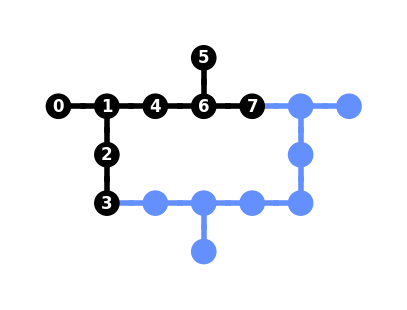

In [85]:
plot_circuit_layout(qcs, ibmq_guadalupe)

#### **Test Trial**

In [10]:
nspin = 2
seed = 10923; name = 'n'+str(nspin)+'sd'+str(seed)
model = random_ising_model(n_spins=nspin, seed= seed, print_model= False)
model.name = name

model.model_summary(plot = False)

            MODEL : n2sd10923
Non-zero Interactions (J) : 1 / 1
Non-zero Bias (h) : 2 / 2
---------------------------------------------
Average Interaction Strength <|J|> :  0.3425
Average Bias Strength <|h|>:  0.19
alpha :  1.909313313651758
---------------------------------------------


In [11]:
samplingjob = QuantumSamplingJob(model=model, backend= ibmq_guadalupe, backend_layout= [1,2])

In [12]:
gamma= 0.4 ; time= 1.0 

qcs = samplingjob.run_quantum_circuit(gamma, time, num_shots= 1, )

Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_provider/ibm_backend.py:431: UserWarning: The backend ibmq_guadalupe is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


Execution Completed in : 2.1999099254608154


In [12]:
qcs.draw()

┌───┐┌─┐┌────────────────┐                   ░ ┌─┐   
q1_0: ┤ H ├┤M├┤ exp(-ia1X+b1Z) ├───────────────────░─┤M├───
      ├───┤└╥┘└──────┬─┬───────┘┌────────────────┐ ░ └╥┘┌─┐
q1_1: ┤ H ├─╫────────┤M├────────┤ exp(-ia0X+b0Z) ├─░──╫─┤M├
      └───┘ ║        └╥┘        └────────────────┘ ░  ║ └╥┘
c2: 2/══════╩═════════╩═══════════════════════════════╬══╬═
            0         1                               ║  ║ 
c3: 2/════════════════════════════════════════════════╩══╩═
                                                      0  1

In [34]:
qcs_tr = transpile(qcs, backend= ibmq_guadalupe, optimization_level= 3, initial_layout= [3,5])

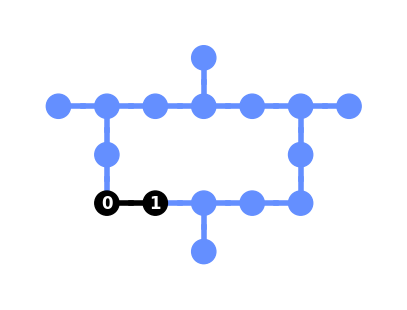

In [37]:
plot_circuit_layout(qcs_tr, ibmq_guadalupe)

In [35]:
qcs_tr.draw()

global phase: 3π/2
                                                                            »
  ancilla_0 -> 0 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_1 -> 1 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_2 -> 2 ───────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐┌─┐┌────────────┐    ┌────┐    »
       q7_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├┤ Rz(1.6942) ├────┤ √X ├────»
                 └─────────┘└────┘└─────────┘└╥┘└────────────┘    └────┘    »
  ancilla_3 -> 4 ─────────────────────────────╫─────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐ ║      ┌─┐      ┌────────────┐»
       q7_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──────┤M├──────┤ Rz(1.3336) ├»
                 └─────────┘└────┘└─────────┘ ║      └╥┘      └────────────┘»
  ancilla_4 -> 6 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_5 -> 7 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_6 -> 8 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_7 -> 9 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_8 -> 10 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_9 -> 11 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_10 -> 12 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_11 -> 13 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_12 -> 14 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_13 -> 15 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
           c4: 2/═════════════════════════════╩═══════╩═════════════════════»
                                              0       1                     »
           c5: 2/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«  ancilla_0 -> 0 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_1 -> 1 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_2 -> 2 ─────────────────────────────────────────────────────────────»
«                 ┌─────────────┐     ┌────┐    ┌────────────┐               ░ »
«       q7_0 -> 3 ┤ Rz(-2.5032) ├─────┤ √X ├────┤ Rz(1.6942) ├───────────────░─»
«                 └─────────────┘     └────┘    └────────────┘               ░ »
«  ancilla_3 -> 4 ─────────────────────────────────────────────────────────────»
«                      ┌────┐    ┌─────────────┐    ┌────┐    ┌────────────┐ ░ »
«       q7_1 -> 5 ─────┤ √X ├────┤ Rz(-2.5074) ├────┤ √X ├────┤ Rz(1.3336) ├─░─»
«                      └────┘    └─────────────┘    └────┘    └────────────┘ ░ »
«  ancilla_4 -> 6 ────────────────────────

In [14]:
with open('DATA/raw-circuit-outputs/sm1id1t0.pickle', 'rb') as hl:
    result = pickle.load(hl)

In [16]:
result.get_counts()

{'00000000 00000000': 261,
 '00000000 00000001': 48,
 '00000000 00010000': 41,
 '00000001 00000000': 4,
 '00010000 00000000': 9,
 '00010000 00000010': 2,
 '00010000 00000100': 3,
 '00010000 00001000': 1,
 '00010000 00001010': 1,
 '00000001 00000001': 169,
 '00010000 00010000': 193,
 '00010000 00010001': 30,
 '00010000 00010010': 32,
 '00010000 00010011': 8,
 '00010000 00010100': 43,
 '00010000 00010101': 11,
 '00010000 00010110': 12,
 '00010000 00010111': 3,
 '00010000 00011000': 37,
 '00010000 00011001': 11,
 '00010000 00011010': 7,
 '00010000 00011011': 4,
 '00010000 00011100': 21,
 '00010000 00011101': 3,
 '00010000 00011110': 5,
 '00000001 00000010': 3,
 '00010000 00100000': 1,
 '00010000 00100010': 1,
 '00010000 00101010': 1,
 '00000001 00000011': 52,
 '00010000 00110000': 41,
 '00010000 00110001': 10,
 '00010000 00110010': 6,
 '00010000 00110011': 3,
 '00010000 00110100': 7,
 '00010000 00110110': 2,
 '00010000 00111000': 6,
 '00010000 00111001': 1,
 '00010000 00111010': 2,
 '0001